In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
#import matplotlib.pyplot as py
#import seaborn as sns
import statsmodels.api as sm

In [3]:
### Input expression data
gene_expr_body = pd.read_table("/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices/VOOMCounts_CPM5_counts4M_covfree_body_ctrl_onlygenesinmainchr_Jul20.21.txt")
gene_expr_head = pd.read_table("/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices/VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21.txt")

In [4]:
gene_expr_dict = {"head": gene_expr_head.T, "body": gene_expr_body.T}

In [5]:
gene_expr_dict["head"].mean(axis=0)

FBgn0031081     5.093763
FBgn0052350     3.535541
FBgn0024733    11.816455
FBgn0040372     3.972505
FBgn0023534     4.186527
                 ...    
FBgn0031318     5.024348
FBgn0031313     6.567976
FBgn0031305     5.238079
FBgn0016926     7.766387
FBgn0003310     4.660298
Length: 5584, dtype: float64

In [6]:
X_head = (gene_expr_dict["head"] - gene_expr_dict["head"].mean()) / np.sqrt(gene_expr_dict["head"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_head_corr = oa.fit(X_head)

X_body = (gene_expr_dict["body"] - gene_expr_dict["body"].mean()) / np.sqrt(gene_expr_dict["body"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_body_corr = oa.fit(X_body)

gene_expr_OAS_corr = {"head": regularized_head_corr, 
                      "body": regularized_body_corr}

In [7]:
g = load_graph("VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21_regularized_correlations_precisions_pvalues_cutoff_1e-6.xml.gz")

In [8]:
g_significant = GraphView(g, g.get_total_degrees(g.get_vertices()) > 1 )
g_significant = GraphView(g_significant, g_significant.get_total_degrees(g_significant.get_vertices()) > 1 )
g_significant

<GraphView object, undirected, with 4977 vertices and 371538 edges, 1 internal vertex property, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f2ca1d1c310, at 0x7f2ca1d3a100>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f2ca1d1c310, at 0x7f2ca1d3a0d0>, False), at 0x7f2ca1d1c310>

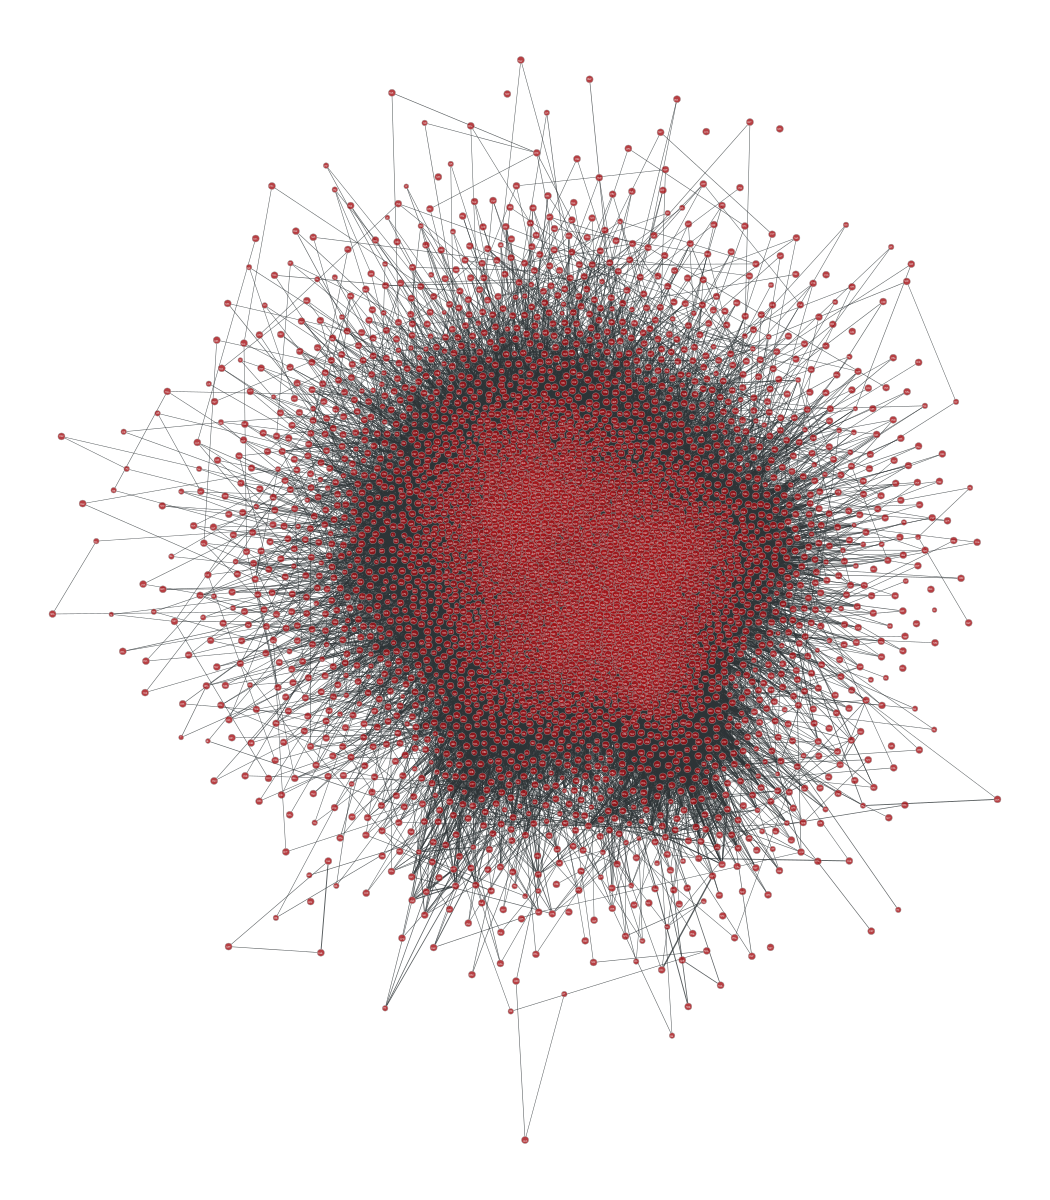

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2ca1d1c310, at 0x7f2ca1d1c640>

In [10]:
graph_draw(g_significant, vertex_text=g.vertex_index, edge_pen_width=g.edge_properties["correlation"])

In [11]:
gf = g.copy()

In [45]:
# Filtering edges
pval = gf.edge_properties["pvalue"]
corr = gf.edge_properties["correlation"]
sign = gf.new_ep("bool", True)
sign.a = np.array(corr.a > 0.4)
gf.set_edge_filter(sign)
gf.purge_edges()

# Keeping largest component
comp, hist = label_components(gf)
main_component = gf.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
gf.vertex_properties["main_component"] = main_component
gf.set_vertex_filter(main_component)
gf.purge_vertices()

In [46]:
N = len(gf.get_vertices())
Et = (N * N - N)/2
E = len(gf.get_edges())
E/Et

0.02431401702016676

In [48]:
gf

<Graph object, undirected, with 1502 vertices and 27408 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2b78adb2e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2aac4af4c0>, False), at 0x7f2ca1d1cbb0>

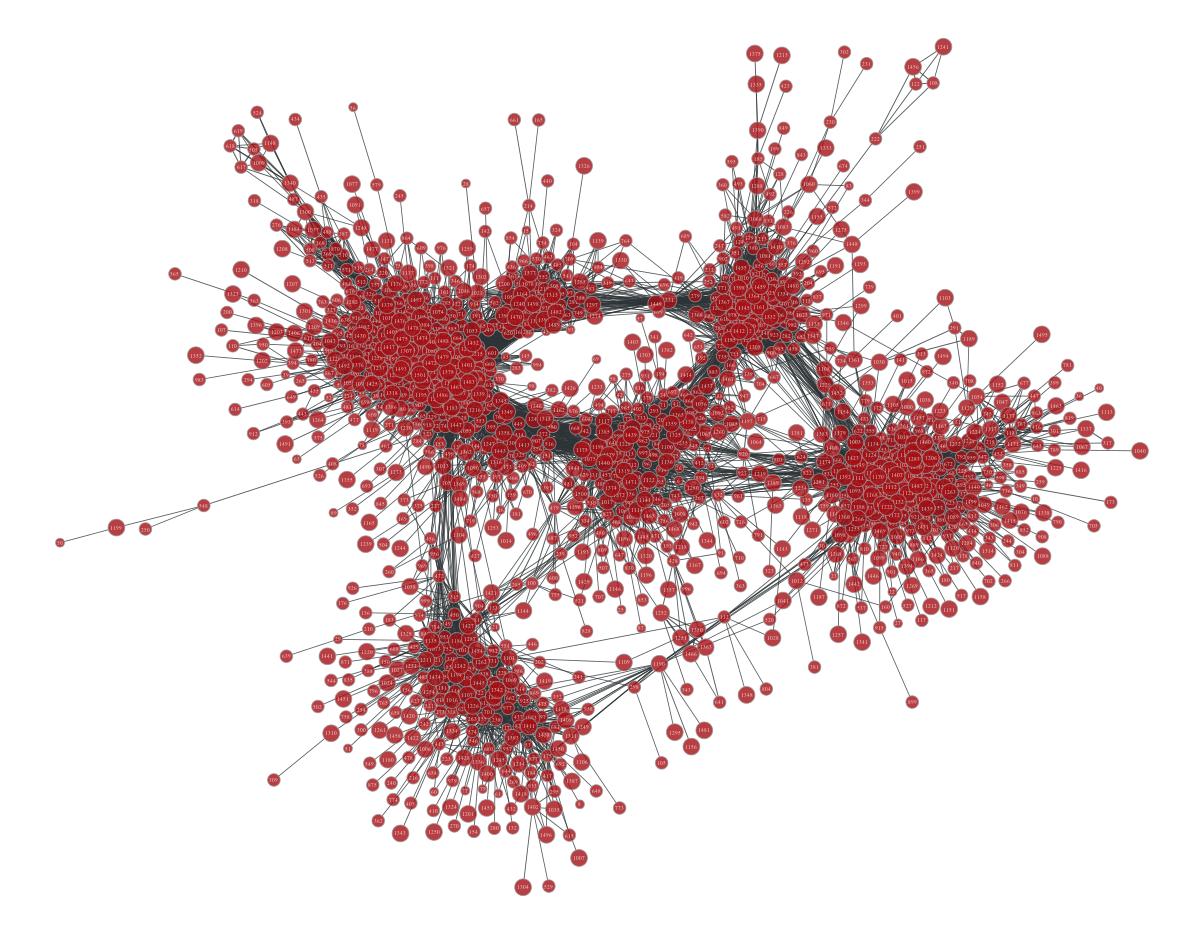

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2ca1d1cbb0, at 0x7f2aab5c33d0>

In [49]:
graph_draw(gf, vertex_text=gf.vertex_index, edge_pen_width=gf.edge_properties["correlation"])

In [71]:
gene_list = []
for i in gf.vertex_properties['genes']:
    gene_list.append(i)
gene_expr_head.T[gene_list].T.to_csv("../data/VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21_filtered_by_correlation-0.4.csv")

In [53]:
corr = gf.edge_properties["correlation"]
n_trials = 10
state_nn_min_list = []
for i in range(n_trials):
    print(i)
    #state_min = minimize_blockmodel_dl(gf, state_args=dict(recs=[corr],
    #                                                       rec_types=["real-normal"]))
    state_min = minimize_blockmodel_dl(gf)
    state_nn_min_list.append(state_min)

0
1
2
3
4
5
6
7
8
9


In [55]:
state_nn_min_list

[<BlockState object with 1502 blocks (32 nonempty), degree-corrected, for graph <Graph object, undirected, with 1502 vertices and 27408 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2b78adb2e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2aac4af4c0>, False), at 0x7f2ca1d1cbb0>, at 0x7f2b79254700>,
 <BlockState object with 1502 blocks (33 nonempty), degree-corrected, for graph <Graph object, undirected, with 1502 vertices and 27408 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2b78adb2e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2aac4af4c0>, False), at 0x7f2ca1d1cbb0>, at 0x7f2b792544c0>,
 <BlockState object with

In [56]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret_nn = []
state_nn_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_nn_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_nn_mcmc_list.append(state)
        ret_nn.append(x)

0
1
2
3
4
5
6
7
8
9


In [58]:
description_lenghts = np.zeros(n_trials)
for j in range(n_trials):
    description_lenghts[j] = state_nn_mcmc_list[j].entropy()
min_index = np.argmin(description_lenghts)
state_min_nn = state_nn_mcmc_list[min_index]
description_lenghts

array([59028.18113783, 59026.06225961, 59025.5182401 , 59027.01703569,
       59030.24224623, 59026.01009692, 59022.16871856, 59026.20079636,
       59027.56895443, 59029.25585465])

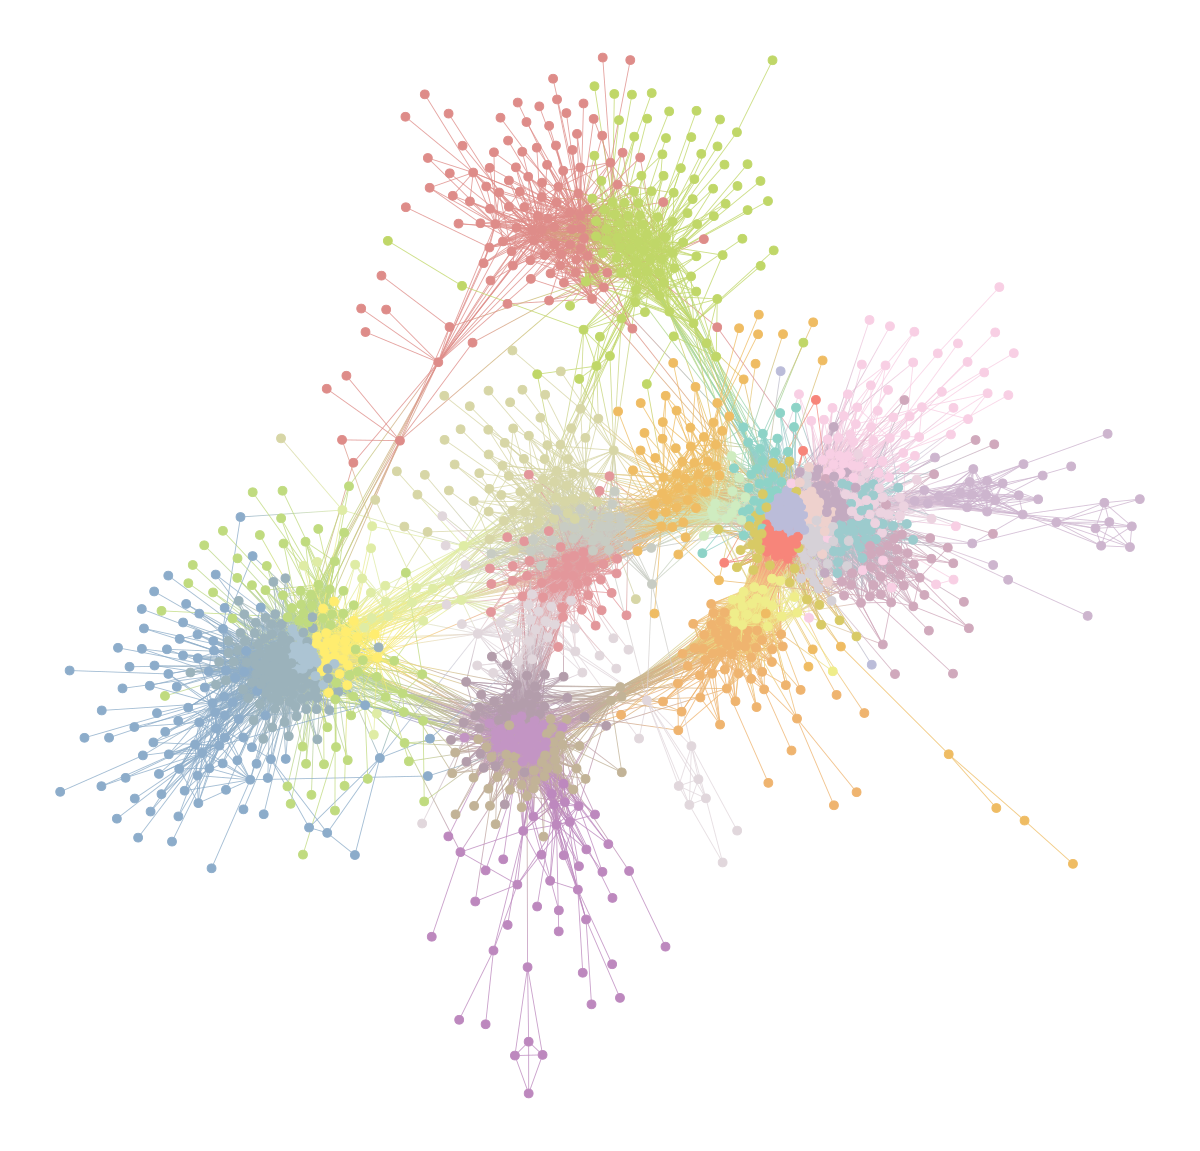

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2ca1d1cbb0, at 0x7f2ca1bef760>

In [59]:
state_min_nn.draw()

In [61]:
def create_Block_df(g, state):
    genes = g.vertex_properties["genes"]
    corr = g.edge_properties["correlation"]
    block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'Block'))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [corr] )[:,2]))
        line.append(state.get_blocks()[v])
        block_df.loc[v] = line
    return block_df

In [62]:
block_df = create_Block_df(gf, state_min_nn)
block_df
block_df.to_csv("../data/1502genes-non_hierarchical_sbm-fit_head_df.csv")

In [63]:
n_trials = 10
state_min_list = []
for i in range(n_trials):
    print(i)
    #state_min = minimize_nested_blockmodel_dl(gf, state_args=dict(recs=[corr],
    #                                                              rec_types=["real-normal"]))
    state_min = minimize_nested_blockmodel_dl(gf)
    state_min_list.append(state_min)

0
1
2
3
4
5
6
7
8
9


In [64]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret = []
state_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_mcmc_list.append(state)
        ret.append(x)

0
1
2
3
4
5
6
7
8
9


In [37]:
description_lenghts = np.zeros(n_trials)
for j in range(n_trials):
    description_lenghts[j] = state_mcmc_list[j].entropy()
min_index = np.argmin(description_lenghts)
state_min = state_mcmc_list[min_index]
description_lenghts

array([238570.79275987, 238425.8898437 , 238446.29169165, 238462.36065319,
       238517.86961173, 238504.36597844, 238506.36640514, 238523.31380946,
       238486.54004084, 238516.82106926])

In [38]:
#state_min.delete_level(5)
levels = state_min.get_levels()
len(levels)

13

In [39]:
levels = state_min.get_levels()
for s in levels:
    print(s)

<BlockState object with 3586 blocks (129 nonempty), degree-corrected, for graph <Graph object, undirected, with 3592 vertices and 115062 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2ca1c68760>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f2ca1d1cbb0, at 0x7f2ca1c6c1c0>, False), at 0x7f2ca1d1cbb0>, at 0x7f2aab5aa0d0>
<BlockState object with 128 blocks (33 nonempty), for graph <Graph object, undirected, with 3586 vertices and 2168 edges, at 0x7f2aab5aa490>, at 0x7f2aab5aa970>
<BlockState object with 27 blocks (12 nonempty), for graph <Graph object, undirected, with 128 vertices and 300 edges, at 0x7f2aab6264f0>, at 0x7f2aab6263d0>
<BlockState object with 12 blocks (4 nonempty), for graph <Graph object, undirected, with 27 vertices and 63 edges, at 0x7f2aab622910>, at 0x7f2aab626070>
<BlockState object with 2 blocks (1 no

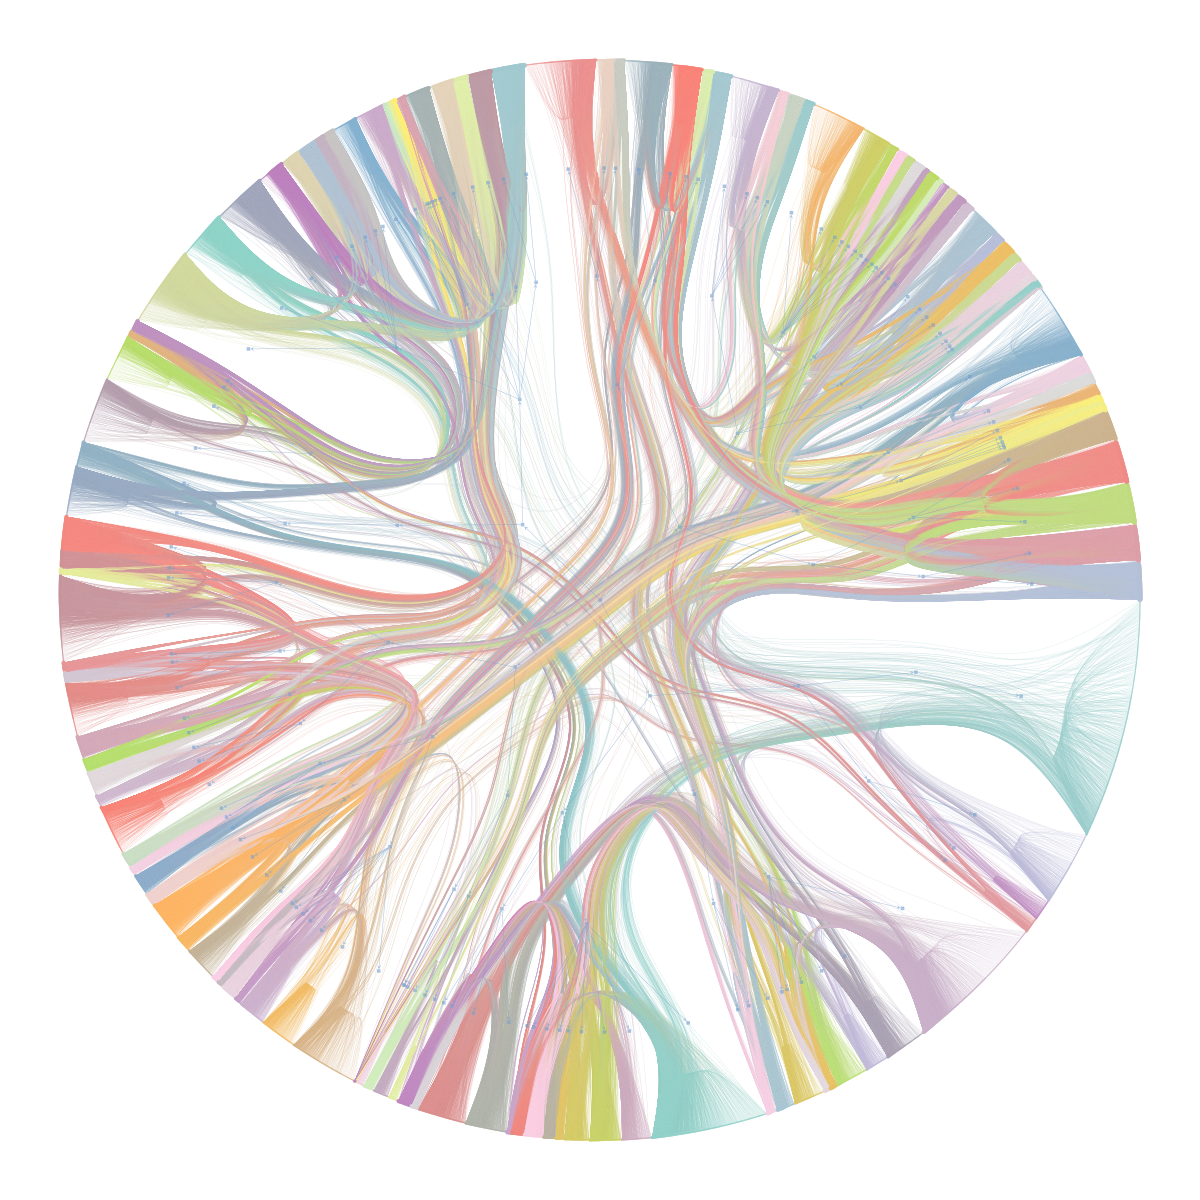

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2ca1d1cbb0, at 0x7f2b8bf64430>,
 <Graph object, directed, with 3771 vertices and 3770 edges, at 0x7f2b8bf94760>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2b8bf94760, at 0x7f2b8bf6a550>)

In [40]:
state_min.draw()

In [ ]:
sns.histplot(state_min_non_nested.b.a)

In [ ]:
state_min.draw(output="../plots/5524genes-hsbm-fit.png")


In [65]:
def get_group(x, state):
    levels = state.get_levels()
    n_levels = 5#len(levels)
    r = np.zeros(n_levels)
    r[0] = levels[0].get_blocks()[x]
    for i in range(1, n_levels):
        r[i] = levels[i].get_blocks()[r[i-1]]
    r = r.astype(int)
    return r
def create_nestedBlock_df(g, state):
    genes = g.vertex_properties["genes"]
    correlation = g.edge_properties["correlation"]
    nested_block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'B1', "B2", "B3", "B4", "B5"))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [correlation] )[:,2]))
        [line.append(i) for i in get_group(v, state)]
        nested_block_df.loc[v] = line
    return nested_block_df

In [66]:
nested_block_df = create_nestedBlock_df(gf, state_min)

In [67]:
nested_block_df

Gene Degree    E_corr    B1  B2  B3 B4 B5
0     FBgn0024733    131  0.497290   726  63  14  6  0
1     FBgn0023537     31  0.432775   552   7   9  6  0
2     FBgn0000108    150  0.469731  1413  69  12  3  0
3     FBgn0002579    154  0.536780   948  14  11  6  0
4     FBgn0026879     46  0.421926  1260  63  14  6  0
...           ...    ...       ...   ...  ..  .. .. ..
1497  FBgn0000579     26  0.452617   441  47   9  6  0
1498  FBgn0021906     67  0.480836   164   0  18  0  0
1499  FBgn0031306     13  0.428610   436  67  12  3  0
1500  FBgn0031313     11  0.434011   571  13  19  6  0
1501  FBgn0031305    123  0.446589   554   6   9  6  0

[1502 rows x 8 columns]

In [69]:
nested_block_df.to_csv("../data/1502genes-Control_Head-hsbm-fit_df.csv")